In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from operator import itemgetter
import folium
from folium import plugins
import community as community_louvain
import os
from time import time
from networkx.algorithms.community import greedy_modularity_communities

In [2]:
file_name='Databike.csv'
dataframe=pd.read_csv(file_name)


In [3]:
dataframe.head()

departure          return  departure_id    departure_name  return_id  \
0  3/23/2020 6:09  3/23/2020 6:16            86          Kuusitie        111   
1  3/23/2020 6:11  3/23/2020 6:26            26        Kamppi (M)         10   
2  3/23/2020 6:16  3/23/2020 6:24           268  Porolahden koulu        254   
3  3/23/2020 6:33  3/23/2020 7:14           751        Vallipolku        106   
4  3/23/2020 6:36  3/23/2020 7:04            62  Länsisatamankatu        121   

        return_name  distance (m)  duration (sec.)  avg_speed (km/h)  \
0     Esterinportti        1747.0              401          0.261397   
1       Kasarmitori        1447.0              869          0.099908   
2       Agnetankuja        1772.0              469          0.226695   
3   Korppaanmäentie        7456.0             2406          0.185935   
4  Vilhonvuorenkatu        7120.0             1679          0.254437   

   departure_latitude  departure_longitude  return_latitude  return_longitude  \
0           60.195245            24.901900        60.197572         24.926781   
1           60.168610            24.930537        60.165017         24.949473   
2           60.195540            25.053581        60.187234         25.036412   
3           60.227827            24.819614        60.203474         24.898930   
4           60.158928            24.909692        60.186463         24.967872   

   Air temperature (degC)  
0                     0.9  
1                     0.9  
2                     0.9  
3                     0.9  
4                     0.9

In [4]:
dataframe[['departure','return']] = dataframe[['departure','return']].apply(pd.to_datetime, format='%m/%d/%Y %H:%M')


dataframe = dataframe.rename(columns={'distance (m)': 'distance',
                                     'duration (sec.)': 'duration',
                                     'avg_speed (km/h)':'speed',
                                      'Air temperature (degC)':'temperature',
                                     })
dataframe = dataframe[
                    (50 < dataframe['distance']) & (dataframe['distance'] < 10000) &
                    (120 < dataframe['duration']) & (dataframe['duration'] <  18000) &
                    (-20 < dataframe['temperature']) & (dataframe['temperature'] < 50)
                    ]

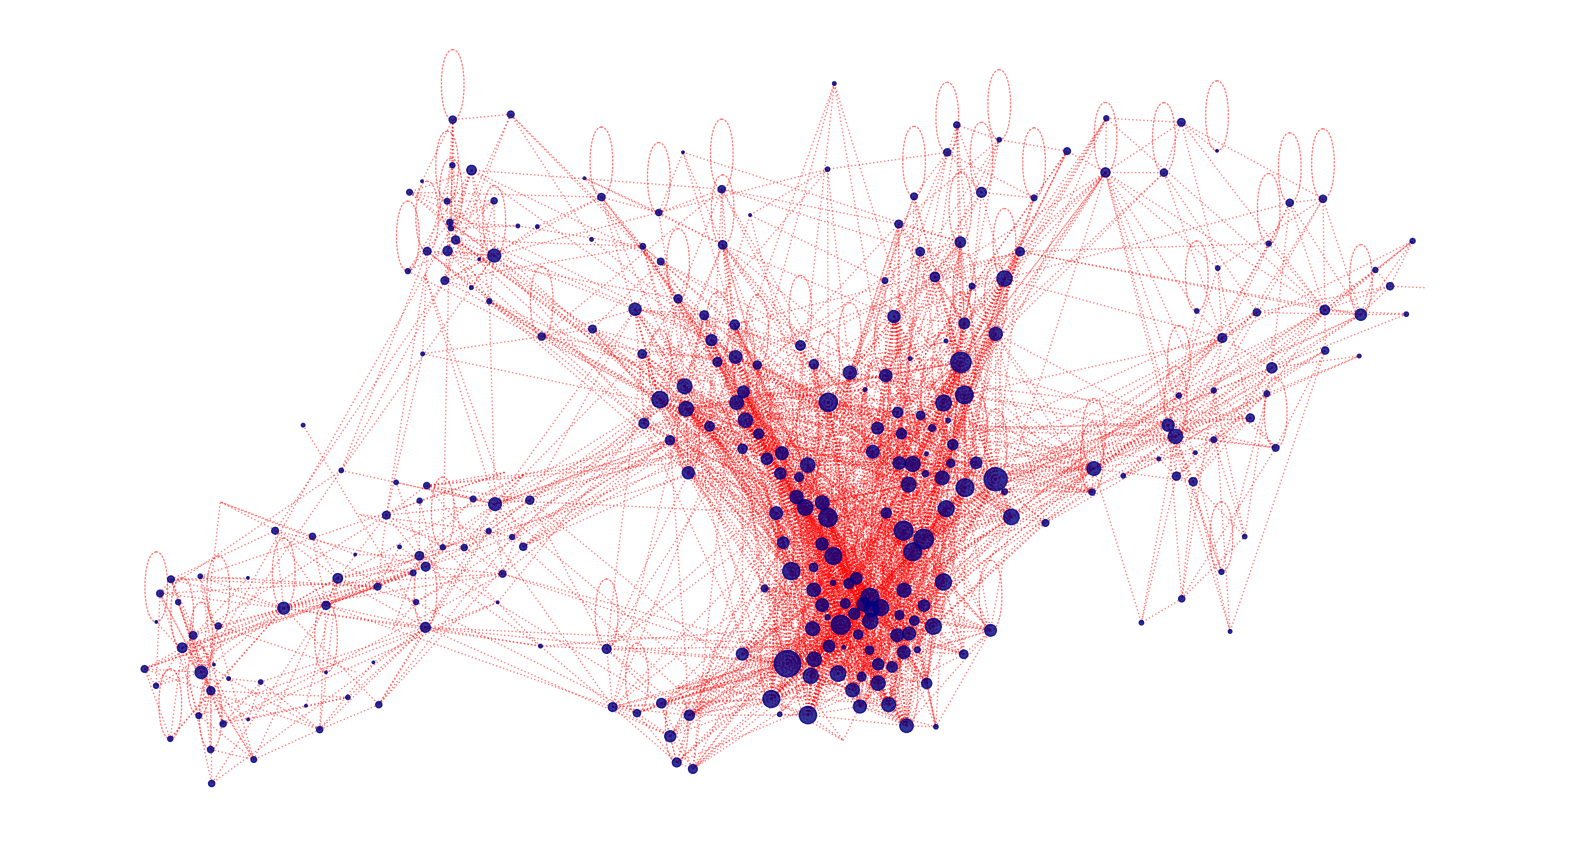

In [5]:
def bikeNetwork(dataframe, year=2020):
    """
    This function plots the City bike network with node sizes illustrating station popularity.
    """
    # Data
    df = dataframe.copy()
    df = df[df['departure'].dt.year == year]
    df.dropna(inplace=True)
    #print(df.isna().sum())

    # Graphs
    G = nx.Graph()
    G = nx.from_pandas_edgelist(df, 'departure_name', 'return_name', edge_attr=['duration','distance'])

    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    # Positions
    stantions  = pd.read_csv("https://raw.githubusercontent.com/Geometrein/helsinki-city-bikes/main/data/downloaded_data/station_coordinates.csv")
    stantions.set_index('name',inplace=True)
    stantions["pos"] = list(zip(stantions["longitude"].astype(float), stantions["latitude"].astype(float)))
    pos = stantions.to_dict()['pos']

    # Map "pos" atribute to nodes from pos dict
    for node, position in pos.items():
        try:
            G.nodes[node]['pos'] = position
        except KeyError:
            pass

    # Draw
    # Calculate node size based on station popularity
    node_sizes = [df['departure_name'].value_counts().get(node, 0) / 15 for node in G.nodes]
    nx.draw_networkx_nodes(G=G, pos=G.nodes.data('pos'), node_color='navy', alpha=0.8, node_size=[s * 50 for s in node_sizes])
    nx.draw_networkx_edges(G=G, pos=G.nodes.data('pos'), edge_color='red', style="dotted", alpha=0.5, arrows=False)
    ax.axis('off')


    return G

G = bikeNetwork(dataframe)

In [6]:
def networkStats(G):
    """
    This function prints the basic properties of the City bike network.
    """
    print("Number of nodes:", G.number_of_nodes())
    print("Number of edges:", G.number_of_edges())
    density = nx.density(G)
    print("Network density:", density)
    triadic_closure = nx.transitivity(G)
    print("Triadic closure:", triadic_closure)

    degree_dict = dict(G.degree(G.nodes()))
    nx.set_node_attributes(G, degree_dict, 'degree')

    sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)
    print("\nTop 5 nodes by degree:\n")
    for d in sorted_degree[:5]:
        print(d)

    betweenness_dict = nx.betweenness_centrality(G) # Compute betweenness centrality
    eigenvector_dict = nx.eigenvector_centrality(G) # Compute eigenvector centrality

    sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)

    print("\nTop 5 nodes by betweenness centrality:\n")
    for b in sorted_betweenness[:5]:
        print(b)

networkStats(G)


Number of nodes: 304
Number of edges: 2471
Network density: 0.05365207573388918
Triadic closure: 0.2631100834090346

Top 5 nodes by degree:

('Itämerentori', 65)
('Kamppi (M)', 55)
('Ympyrätalo', 55)
('Kalasatama (M)', 54)
('Töölönlahdenkatu', 53)

Top 5 nodes by betweenness centrality:

('Haukilahdenkatu', 0.05947784649495453)
('Laajalahden aukio', 0.05828065885423104)
('Urheilupuisto (M)', 0.05603713098344486)
('Westendinasema', 0.055089937074900286)
('Itämerentori', 0.05158686010562187)


In [7]:
def mapPlot(dataframe, year = 2020):
    """
    This function prints an interactive bubble plot by destination locations for a given year.
    """
    # Data
    df = dataframe.copy()
    df = df[df['departure'].dt.year == year]
    #df = df[:1000]
    df.dropna(inplace=True)
    df['freq'] = df.groupby('departure_name')['departure_name'].transform('count')
    #print(df.isna().sum())
    df["name"] = df["departure_name"]
    df = df[["name", "freq"]]
    df = df.drop_duplicates(subset=['name'])
    freq_dict = dict(zip(df.name, df.freq))

    df_stations = pd.read_csv("https://raw.githubusercontent.com/Geometrein/helsinki-city-bikes/main/data/downloaded_data/station_coordinates.csv", index_col=False)
    df_stations = df_stations[df_stations["latitude"]<=60.254011]
    #print(df_stations.head())
    df_stations['freq']= df_stations['name'].map(freq_dict)
    #print(df_stations.head(), df_stations.isna().sum(), len(df_stations))
    df_stations["freq_adj"] = df_stations['freq']/(df_stations['freq'].median()/3)
    df_stations.fillna(1, inplace=True)
    df_stations.dropna(inplace=True)

    # Map
    hel_map = folium.Map([60.1975594, 24.9320720], zoom_start=12)
    folium.TileLayer('cartodbdark_matter').add_to(hel_map)

    for index, row in df_stations.iterrows():
        folium.CircleMarker([row['latitude'],row['longitude']],
                        radius=row["freq_adj"],
                        popup=row['freq'],
                        color="#eab544",
                        fill_color="#eab544",
                    ).add_to(hel_map)

    display(hel_map)

mapPlot(dataframe)

In [8]:
def heatMapPlot(dataframe, year = 2020):
    """
    This function prints an interactive heatmap by destination locations for a given year.
    """
    # Data
    df = dataframe.copy()
    df = df[df['departure'].dt.year == year]

    df.dropna(inplace=True)
    df['freq'] = df.groupby('departure_name')['departure_name'].transform('count')

    # Map
    hel_map = folium.Map([60.1975594, 24.9320720], zoom_start=12)
    folium.TileLayer('cartodbdark_matter').add_to(hel_map)

    stationArr = df[['departure_latitude', 'departure_longitude']].to_numpy()
    hel_map.add_child(plugins.HeatMap(stationArr, radius=15))

    display(hel_map)

heatMapPlot(dataframe)

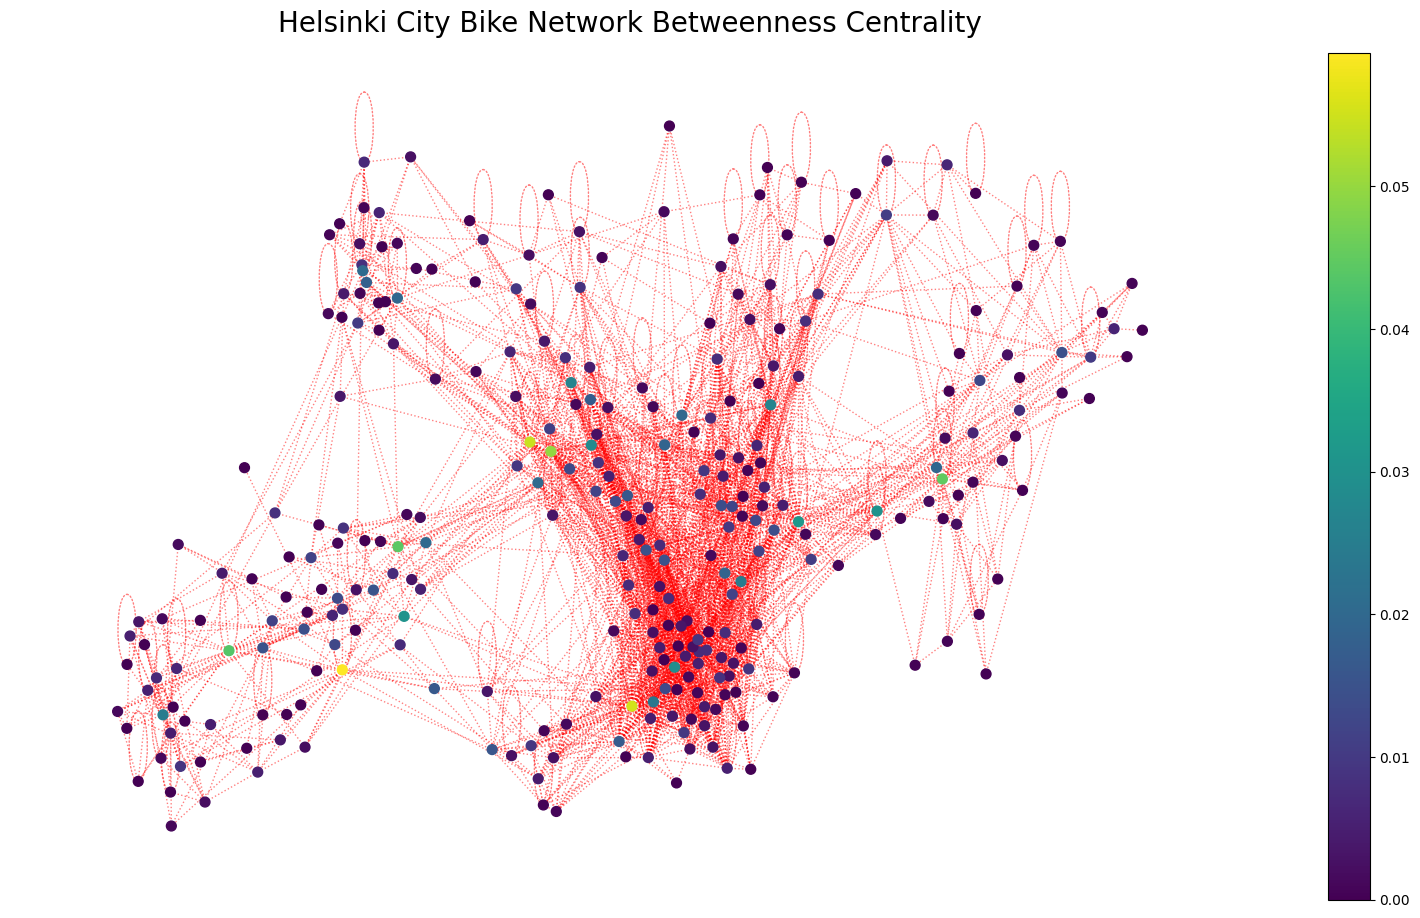

In [9]:
def centralityBetweenness(Graph):
    """
    This function plots the city bike network betweenes centrality
    """

    G = Graph.copy(as_view=False)
    G.remove_node("Haukilahdenkatu")

    # Figure
    fig, ax = plt.subplots(figsize=(20,11))



    betweenness = nx.betweenness_centrality(G)
    node_color = [betweenness[i] for i in betweenness.keys()]

    # Color scale
    colors = range(20)
    cmap = plt.cm.viridis
    vmin = min(node_color)
    vmax = max(node_color) - (sum(node_color) / len(node_color))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm, ax=ax)  # Pass the ax object to colorbar()

    # Draw
    nx.draw_networkx_nodes(G=G, pos=G.nodes.data('pos'), node_color=node_color, cmap="viridis", alpha=1, node_size=50)
    nx.draw_networkx_edges(G=G, pos=G.nodes.data('pos'), edge_color='red', style="dotted", alpha=0.5, arrows=False)

    # Labeling Axes
    ax.set_title('Helsinki City Bike Network Betweenness Centrality', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')

centralityBetweenness(G)

In [10]:
node_names = {
    0: 'Node 0',
    1: 'Node 1',
    2: 'Node 2',
    3: 'Node 3',
    4: 'Node 4'}

C:\Users\kravi\AppData\Local\Temp\ipykernel_15676\3168256625.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20b', max(partition_dict.values()) + 1)


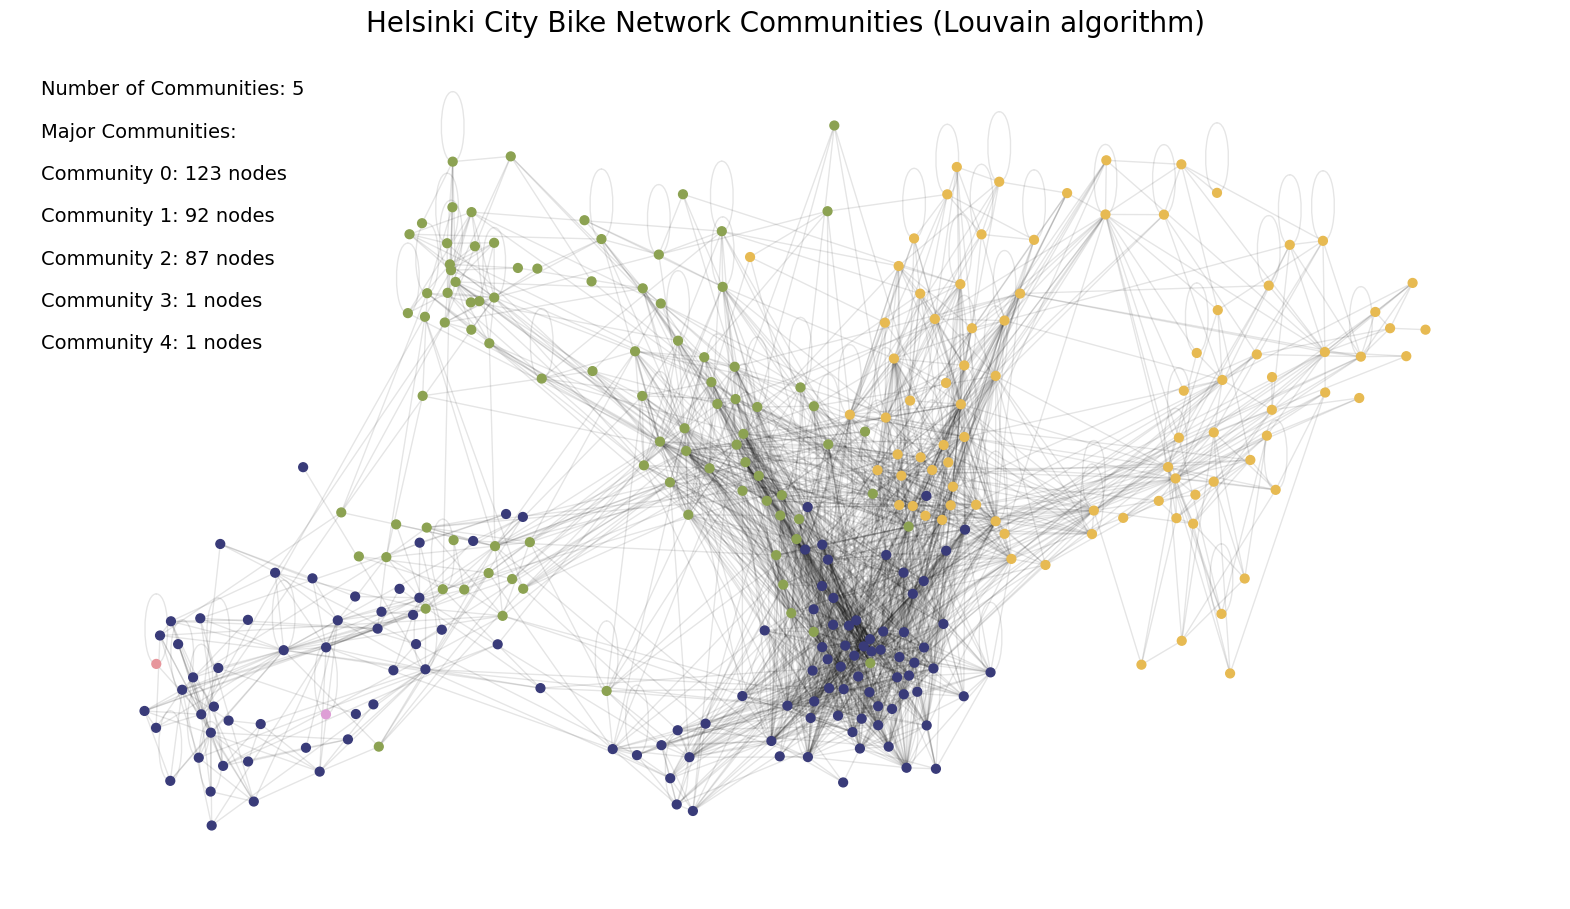

In [11]:
def communityLouvain(G, top_n=5):
    """
    This function applies the Louvain algorithm for community detection on the City bike network.
    """

    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    # Compute communities using Louvain algorithm
    communities = list(greedy_modularity_communities(G))

    # Convert communities to list of clusters
    partition = [tuple(sorted(c)) for c in communities]

    # Convert partition to dictionary format
    partition_dict = {i: idx for idx, cluster in enumerate(partition) for i in cluster}

    # Partition colormap
    cmap = plt.cm.get_cmap('tab20b', max(partition_dict.values()) + 1)

    # Draw Nodes & Edges
    nx.draw_networkx_nodes(G, G.nodes.data('pos'), partition_dict.keys(), node_size=40, cmap=cmap, node_color=list(partition_dict.values()))
    nx.draw_networkx_edges(G, G.nodes.data('pos'), alpha=0.1)

    # Labeling Axes
    ax.set_title('Helsinki City Bike Network Communities (Louvain algorithm)', fontdict={"fontsize":20}, pad=15)
    ax.axis('off')

    # Show the number of communities
    num_communities = len(partition)
    plt.text(0.02, 0.95, f'Number of Communities: {num_communities}', transform=ax.transAxes, fontsize=14)

    # Show major communities
    community_sizes = {i: len(cluster) for i, cluster in enumerate(partition)}
    sorted_communities = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)[:top_n]
    plt.text(0.02, 0.90, 'Major Communities:', transform=ax.transAxes, fontsize=14)
    for idx, (community, size) in enumerate(sorted_communities):
        plt.text(0.02, 0.85 - idx * 0.05, f'Community {community}: {size} nodes', transform=ax.transAxes, fontsize=14)

    plt.show()

# Assuming you have your graph G defined somewhere before calling this function
communityLouvain(G)


In [12]:
def communityLouvaintime(G, top_n=5):
    """
    This function applies the Louvain algorithm for community detection on the City bike network.
    """

    # Compute communities using Louvain algorithm
    communities = greedy_modularity_communities(G)

    # Convert communities to list of clusters
    partition = [tuple(sorted(c)) for c in communities]

    # Convert partition to dictionary format
    partition_dict = {i: idx for idx, cluster in enumerate(partition) for i in cluster}

    return partition_dict

# Assuming G is defined somewhere in your code

# Call communityLouvain function
communityLouvaintime(G)

# Initialize a dictionary to store the communities for each top_n value
communities_dict = dict()

# Initialize a dictionary to store the computation times
times = dict()

# List of top_n values to evaluate
top_n_values = [1, 2, 3, 4, 5]

for top_n in top_n_values:
    start_time = time()
    communities_dict[top_n] = communityLouvaintime(G, top_n)
    times[top_n] = time() - start_time

for top_n, t in times.items():
    print(f'Time for computing the communities with top_n={top_n}:', f'{t:.2f} s')

print()
print(f'Total time for computing the communities:', f'{sum(times.values()):.2f} s')


Time for computing the communities with top_n=1: 0.27 s
Time for computing the communities with top_n=2: 0.31 s
Time for computing the communities with top_n=3: 0.26 s
Time for computing the communities with top_n=4: 0.24 s
Time for computing the communities with top_n=5: 0.17 s

Total time for computing the communities: 1.25 s


C:\Users\kravi\AppData\Local\Temp\ipykernel_15676\1678346194.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20b', max(partition_dict.values()) + 1)


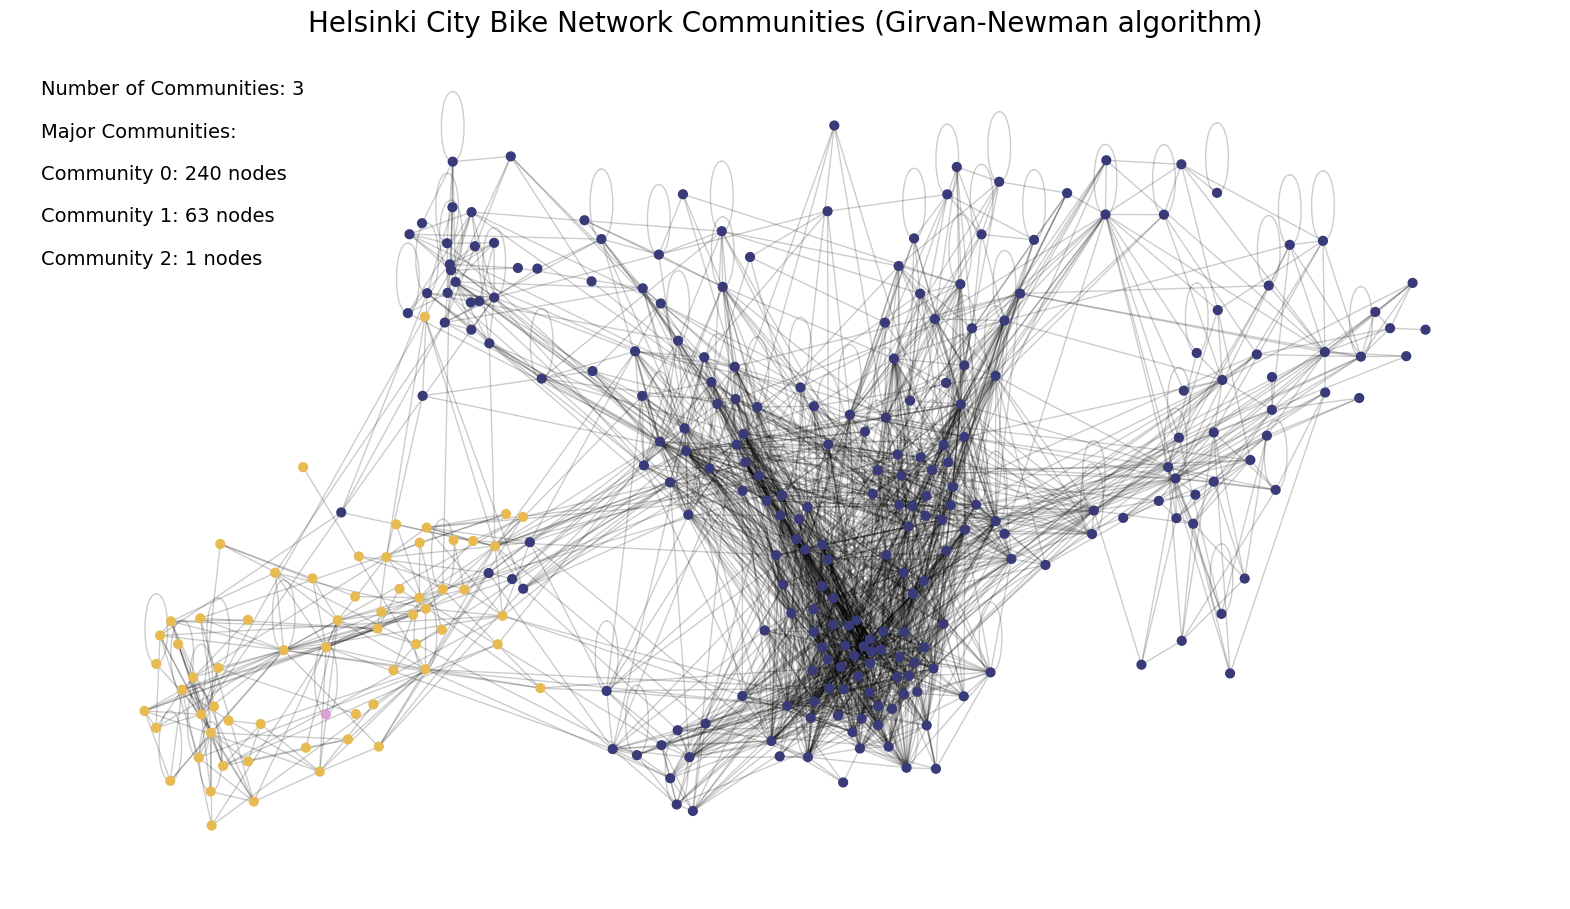

In [16]:
import networkx as nx
import matplotlib.pyplot as plt

def communityGirvanNewman(G, top_n=5):
    """
    This function applies the Girvan-Newman algorithm for community detection on the City bike network.
    """

    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    # Compute communities using Girvan-Newman algorithm
    communities = nx.community.girvan_newman(G)

    # Convert communities to list of clusters
    partition = [tuple(sorted(c)) for c in next(communities)]

    # Convert partition to dictionary format
    partition_dict = {i: idx for idx, cluster in enumerate(partition) for i in cluster}

    # Partition colormap
    cmap = plt.cm.get_cmap('tab20b', max(partition_dict.values()) + 1)

    # Draw Nodes & Edges
    nx.draw_networkx_nodes(G, G.nodes.data('pos'), partition_dict.keys(), node_size=40, cmap=cmap, node_color=list(partition_dict.values()))
    nx.draw_networkx_edges(G, G.nodes.data('pos'), alpha=0.2)

    # Labeling Axes
    ax.set_title('Helsinki City Bike Network Communities (Girvan-Newman algorithm)', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')

    # Show the number of communities
    num_communities = len(partition)
    plt.text(0.02, 0.95, f'Number of Communities: {num_communities}', transform=ax.transAxes, fontsize=14)

    # Show major communities
    community_sizes = {i: len(cluster) for i, cluster in enumerate(partition)}
    sorted_communities = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)[:top_n]
    plt.text(0.02, 0.90, 'Major Communities:', transform=ax.transAxes, fontsize=14)
    for idx, (community, size) in enumerate(sorted_communities):
        plt.text(0.02, 0.85 - idx * 0.05, f'Community {community}: {size} nodes', transform=ax.transAxes, fontsize=14)

    plt.show()

communityGirvanNewman(G)


In [17]:
def communityGirvanNewmantime(G, top_n=3):
    """
    This function applies the Girvan-Newman algorithm for community detection on the City bike network.
    """

    # Compute communities using Girvan-Newman algorithm
    communities = nx.community.girvan_newman(G)

    # Convert communities to list of clusters
    partition = [tuple(sorted(c)) for c in next(communities)]

    # Convert partition to dictionary format
    partition_dict = {i: idx for idx, cluster in enumerate(partition) for i in cluster}

    return partition_dict


communityGirvanNewmantime(G)

# Initialize a dictionary to store the communities for each top_n value
communities_dict = dict()

# Initialize a dictionary to store the computation times
times = dict()

# List of top_n values to evaluate
top_n_values = [1, 2, 3, 4, 5]

for top_n in top_n_values:
    start_time = time()
    communities_dict[top_n] = communityGirvanNewmantime(G, top_n)
    times[top_n] = time() - start_time

for top_n, t in times.items():
    print(f'Time for computing the communities with top_n={top_n}:', f'{t:.2f} s')

print()
print(f'Total time for computing the communities:', f'{sum(times.values()):.2f} s')


Time for computing the communities with top_n=1: 22.80 s
Time for computing the communities with top_n=2: 23.69 s
Time for computing the communities with top_n=3: 22.51 s
Time for computing the communities with top_n=4: 22.47 s
Time for computing the communities with top_n=5: 22.43 s

Total time for computing the communities: 113.90 s


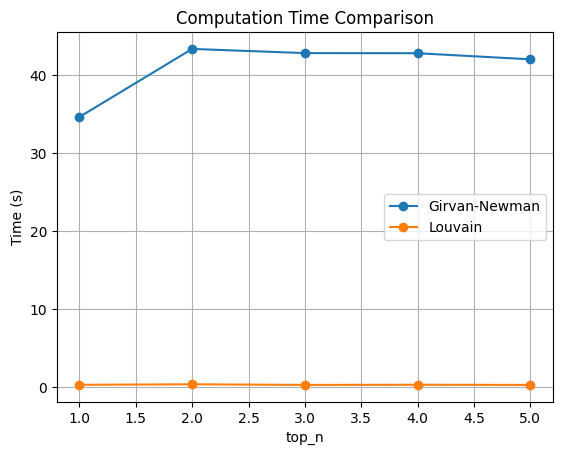

In [19]:
# Plot the results
plt.plot(list(times_girvan_newman.keys()), list(times_girvan_newman.values()), label='Girvan-Newman', marker='o')
plt.plot(list(times_louvain.keys()), list(times_louvain.values()), label='Louvain', marker='o')

plt.xlabel('top_n')
plt.ylabel('Time (s)')
plt.title('Computation Time Comparison')
plt.legend()
plt.grid(True)
plt.show()
